In [69]:
import pickle
import numpy as np
import sympy
import pandas as pd
import sys
import time
import cartpole_error_monitoring

def load_from_file(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        F = data['F']
        lmd_time_series = data['lmd_time_series']
        state_time_series = data['state_time_series']
    return F, lmd_time_series, state_time_series


F, lmd_time_series, state_time_series= load_from_file('./log/symbolic_F.pkl')


In [70]:
for i in range(F.shape[1]):
    variables = set()
    matrix = F[i,0]
    variables.update(matrix.free_symbols)
    # print(list(variables))

for i in range(state_time_series.shape[0]):
    for j in range(state_time_series.shape[1]):
        variables = set()
        matrix = state_time_series[i,j]
        variables.update(matrix.free_symbols)
        # print(list(variables))

for i in range(lmd_time_series.shape[0]):
    for j in range(lmd_time_series.shape[1]):
        variables = set()
        matrix = lmd_time_series[i,j]
        variables.update(matrix.free_symbols)
        # print(list(variables))


In [71]:
project_name = "cartpole_error_monitoring"
# 読み込みたいファイル名のリスト
filenames = ['./log/'+project_name+'_uopt.log', './log/'+project_name+'_x.log', './log/'+project_name+'_t.log']

# 各ファイルを読み込み、その結果をリストに保存します
df_list = [pd.read_csv(filename, delim_whitespace=True, header=None) for filename in filenames]

# 各データフレームをnumpyの行列に変換し、それをリストに保存します
u_matrix, x_matrix, t = [df.values for df in df_list]


simulation step: 10000
0
x[0] = [0. 0. 0. 0.]
U = [(u0_0, 0.01), (u0_1, 0.01), (u0_2, 0.01), (u0_3, 0.01), (u0_4, 0.01)]
F_val = -6.45160454467901
F_val = -5.62336552224823
F_val = -7.37956857684825
F_val = -6.95208110709463
F_val = -4.96293641639166
14.165650107598582
computation time in 0 step: 31.191194
1
x[0] = [ 2.50000e-09 -4.99999e-09  5.00000e-06 -9.99996e-06]
U = [(u0_0, 1.77331), (u0_1, 0.933096), (u0_2, 1.4965), (u0_3, 1.5581), (u0_4, 1.04884)]
F_val = -0.999982031375214
F_val = -0.731723865473390
F_val = 0.113665445345143
F_val = 0.423555738088630
F_val = 0.206402590378360
1.3305281674676532
computation time in 1 step: 62.775570
2
x[0] = [ 4.50827e-07 -9.01652e-07  8.91653e-04 -1.78330e-03]
U = [(u0_0, 2.16093), (u0_1, 1.1442), (u0_2, 1.27023), (u0_3, 1.20721), (u0_4, 0.883497)]
F_val = -0.403342455945192
F_val = -0.304951743600346
F_val = -0.0901768092433016
F_val = -0.0236902455298433
F_val = -0.0521450237055483
0.5168103045108613
computation time in 2 step: 94.046155


Text(0.5, 0, 'Time (s)')

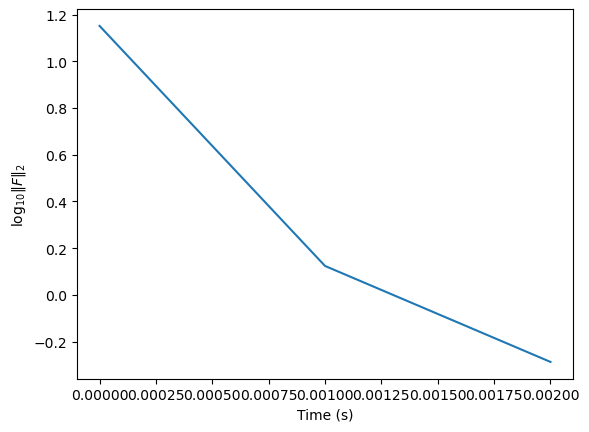

In [72]:
import os, json
from math import sqrt

from matplotlib import pyplot as plt

config_name = 'config_20230722.json'

with open('./config/'+config_name, 'r') as f:
    config = json.load(f)

# Create and configure the AutoGenU object
auto_gen_u = cartpole_error_monitoring.create_autogenu_object(config)
cartpole_error_monitoring.set_parameters(auto_gen_u, config)


x = sympy.Matrix(sympy.symbols(f'x0:{config["nx"]}'))  # Initial state as variables
u = sympy.Matrix([sympy.symbols(f'u{i}_{j}') for i in range(config["nu"]) for j in range(config["N"])]).reshape(config["nu"], config["N"])
r = sympy.symbols('r[0:%d]' %(config["nu"]))
q_terminal = sympy.symbols('q_terminal[0:%d]' %(config["nx"]))
q = sympy.symbols('q[0:%d]' %(config["nx"]))
x_ref = sympy.symbols('x_ref[0:%d]' %(config["nx"]))


sub_param = auto_gen_u.make_subs_dicts()

# Create a list to store the L2 norms and F values
l2_norms = []
F_param_substituted = []

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
print("simulation step:", simulation_steps)
step = 3
start_time = time.time()
# for k in range(int(config["simulation_length"]/config["sampling_time"])):
for k in range(step):
    print(k)
    # Create the substitutions for the state and input at the current time step
    subs_x = [(x[l], x_matrix[k,l]) for l in range(config["nx"])]
    # if k == 0:
    #     subs_u = [(u[l], config["solution_initial_guess"][0]) for l in range(config["N"])]
    # else:
    subs_u = [(u[l], u_matrix[k,l]) for l in range(config["N"])]
    print(f"x[0] = {x_matrix[k,:]}")
    print(f"U = {subs_u}")

    # Create a list to store the F values for the current time step
    F_param_substituted_step = []

    # Loop over the control inputs
    norm = 0
    for i in range(config["N"]):
        for j in range(config["nu"]):
            # Calculate the value of F
            F_val = F[i,j].subs(sub_param).subs(subs_x).subs(subs_u)
            F_param = F[i,j].subs(sub_param)
            F_param_substituted_step.append(F_param)
            
            # Add to the squared L2 norm
            norm += F_val**2
            print(f"F_val = {F_val}")
    
    # if k%50 == 0:
    #     print(k)
    # Append the square root of the norm (i.e., the L2 norm) to the list
    l2_norms.append(sqrt(norm))
    print(sqrt(norm))
    end_time = time.time()
    print("computation time in %d step: %f" % (k, end_time - start_time))


    # Append the F values for the current step to the list
    # F_param_substituted.append(F_param_substituted_step)

simulation_steps = int(config["simulation_length"]/config["sampling_time"])
t_series = [item for sublist in t[0:step] for item in sublist]
result = np.log10(l2_norms)
plt.plot(t_series,result)
plt.ylabel(r'$\log_{10}\Vert F \Vert_2$')
plt.xlabel('Time (s)')